In [1]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=ed2bf30266210576a6b4de5a0cc589cdaab42582375d9d07e70b7d9463e70807
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet_pytorch


In [3]:
from efficientnet_pytorch import EfficientNet
import torchvision.models as models

In [4]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# CSV와 이미지 디렉토리 경로
csv_path = "/content/drive/MyDrive/LAB/data/labels.csv"
img_dir = "/content/drive/MyDrive/LAB/data/images"
# CSV 불러오기
df = pd.read_csv(csv_path)
df["filepath"] = df["filename"].apply(lambda x: os.path.join(img_dir, x))
df["label"] = df["filename"].apply(lambda x: x.split("_")[0])
print(df.head())

            filename     score  \
0  Dripping_0001.png -0.683363   
1  Dripping_0002.png -0.698806   
2  Dripping_0003.png -0.593430   
3  Dripping_0004.png -0.727468   
4  Dripping_0005.png -0.740760   

                                            filepath     label  
0  /content/drive/MyDrive/LAB/data/images/Drippin...  Dripping  
1  /content/drive/MyDrive/LAB/data/images/Drippin...  Dripping  
2  /content/drive/MyDrive/LAB/data/images/Drippin...  Dripping  
3  /content/drive/MyDrive/LAB/data/images/Drippin...  Dripping  
4  /content/drive/MyDrive/LAB/data/images/Drippin...  Dripping  


In [5]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(), transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)

In [6]:
print(df.tail())

             filename  score  \
4325  Multi_00982.png  0.457   
4326  Multi_00983.png  0.323   
4327  Multi_00984.png  0.364   
4328  Multi_00985.png  0.324   
4329  Multi_00986.png  0.407   

                                               filepath  label  
4325  /content/drive/MyDrive/LAB/data/images/Multi_0...  Multi  
4326  /content/drive/MyDrive/LAB/data/images/Multi_0...  Multi  
4327  /content/drive/MyDrive/LAB/data/images/Multi_0...  Multi  
4328  /content/drive/MyDrive/LAB/data/images/Multi_0...  Multi  
4329  /content/drive/MyDrive/LAB/data/images/Multi_0...  Multi  


In [7]:
##### print("유효한 데이터 개수:", len(df))
print("라벨 분포:\n", df["label"].value_counts())

df["is_multi"] = df["label"].eq("Multi")
print("멀티 라벨 개수:", df["is_multi"].sum())

라벨 분포:
 label
Dripping    2340
ConeJet     1004
Multi        986
Name: count, dtype: int64
멀티 라벨 개수: 986


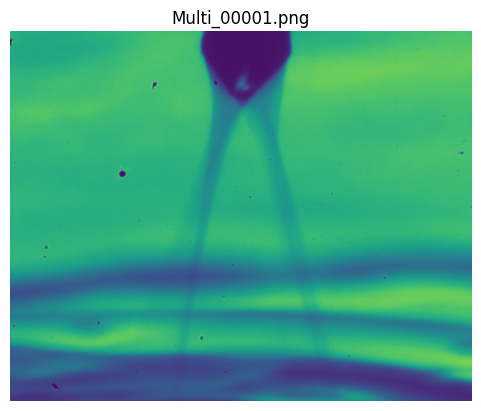

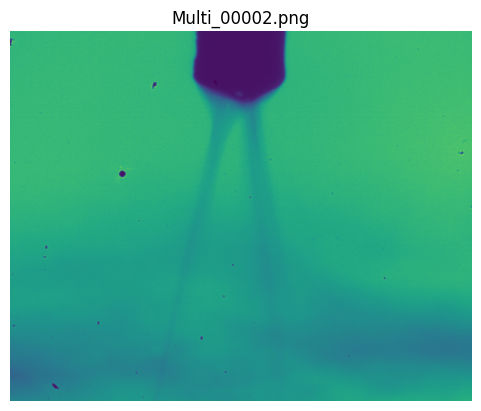

In [8]:
multi_files = df[df["label"]=="Multi"]["filepath"].tolist()[:2]

for f in multi_files:
    if os.path.exists(f):
        img = Image.open(f)
        plt.imshow(img)
        plt.title(os.path.basename(f))
        plt.axis("off")
        plt.show()
    else:
        print(f, "없음")

In [9]:
multi_df = df[df["is_multi"]].copy()

aug_dir = "/datalab"
os.makedirs(aug_dir, exist_ok=True)

aug_rows = []

for idx, row in multi_df.iterrows():
    img_path = row["filepath"]
    if not os.path.exists(img_path):
        continue  # 혹시 없는 파일은 스킵

    img = Image.open(img_path)

    # 좌우 반전
    flipped_img = ImageOps.mirror(img)

    # 새로운 파일명
    base, ext = os.path.splitext(row["filename"])
    new_filename = base + "_flip" + ext
    new_filepath = os.path.join(aug_dir, new_filename)

    # 반전 이미지 저장
    flipped_img.save(new_filepath)

    # 새로운 row 정보 추가
    aug_rows.append({
        "filename": new_filename,
        "score": row["score"],
        "filepath": new_filepath,
        "label": row["label"],  # Multi 그대로
        "is_multi": True
    })

In [10]:
# 증강 데이터프레임
aug_df = pd.DataFrame(aug_rows)

# 원본 + 증강 합치기
df_augmented = pd.concat([df, aug_df], ignore_index=True)

# CSV 저장
aug_csv_path = "/datalab/labels_augmented.csv"
df_augmented.to_csv(aug_csv_path, index=False)

print("증강된 데이터 크기:", len(aug_df))
print("최종 데이터 크기:", len(df_augmented))
print("증강된 CSV 저장 위치:", aug_csv_path)
print("최종 라벨 분포:\n", df_augmented['label'].value_counts())

증강된 데이터 크기: 986
최종 데이터 크기: 5316
증강된 CSV 저장 위치: /datalab/labels_augmented.csv
최종 라벨 분포:
 label
Dripping    2340
Multi       1972
ConeJet     1004
Name: count, dtype: int64


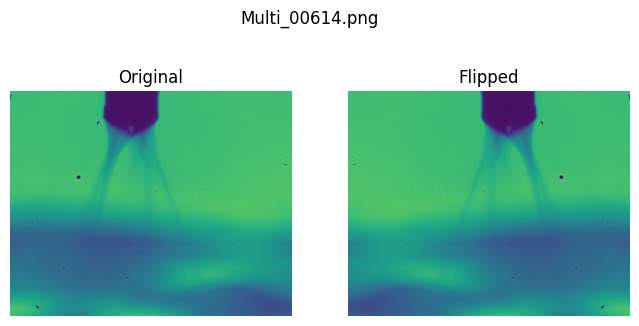

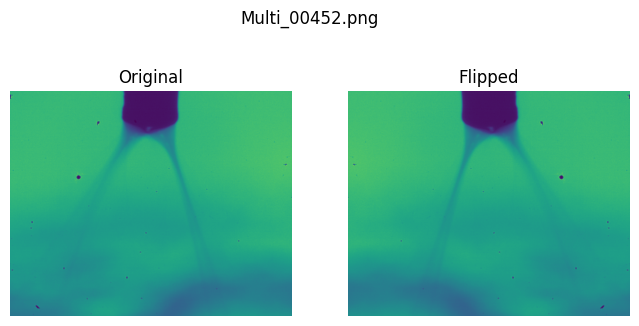

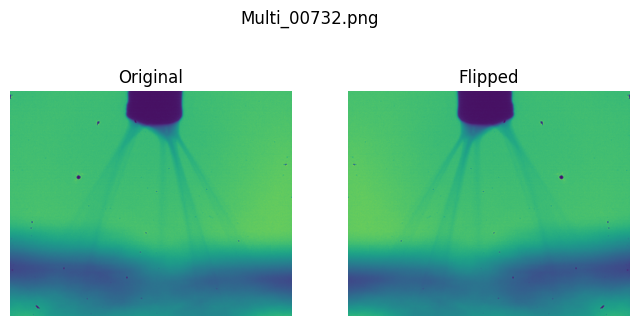

In [11]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Multi 중에서 증강된 파일 3개 샘플 확인
sample_aug = aug_df.sample(3, random_state=42)

for _, row in sample_aug.iterrows():
    # 증강된 파일명에서 "_flip" 제거 -> 원본 파일명
    orig_filename = row["filename"].replace("_flip", "")
    orig_path = os.path.join(img_dir, orig_filename)
    aug_path = row["filepath"]

    if not os.path.exists(orig_path):
        print("원본 없음:", orig_path)
        continue
    if not os.path.exists(aug_path):
        print("증강본 없음:", aug_path)
        continue

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # 원본 이미지
    orig_img = Image.open(orig_path)
    axes[0].imshow(orig_img)
    axes[0].set_title("Original")
    axes[0].axis("off")

    # 반전 이미지
    aug_img = Image.open(aug_path)
    axes[1].imshow(aug_img)
    axes[1].set_title("Flipped")
    axes[1].axis("off")

    plt.suptitle(orig_filename)
    plt.show()

In [12]:
# EfficientNet 기반 회귀모델
!pip install efficientnet_pytorch

import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class EfficientNetRegressor(nn.Module):
    def __init__(self, model_name='efficientnet-b0', pretrained=True):
        super(EfficientNetRegressor, self).__init__()
        # EfficientNet 불러오기
        self.base_model = EfficientNet.from_pretrained(model_name) if pretrained else EfficientNet.from_name(model_name)

        # 기존 classification layer (fully connected layer) 교체
        in_features = self.base_model._fc.in_features
        self.base_model._fc = nn.Identity()  # 기존 FC 제거

        # 회귀용 출력층 추가 (출력 1개)
        self.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        return x

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [14]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class ImageRegressionDataset(Dataset):
    def __init__(self, dataframe, transform=None, return_label=False):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        self.return_label = return_label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img = Image.open(row["filepath"]).convert("RGB")

        if self.transform:
            img = self.transform(img)

        # score는 regression target
        score = torch.tensor(row["score"], dtype=torch.float32)

        if self.return_label:
            return img, score, row["label"]  # (이미지, 점수, 라벨)
        else:
            return img, score

In [15]:
from torch.utils.data import DataLoader, random_split

# 학습 데이터셋 (label 반환 X → score만 regression target)
full_dataset = ImageRegressionDataset(
    df_augmented, transform=transform, return_label=False
)

# Train/Val split (80:20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))

Train size: 4252
Val size: 1064


In [16]:
# Plot용 데이터셋 (label 반환 O)
plot_dataset = ImageRegressionDataset(df, transform=transform, return_label=True)
plot_loader = DataLoader(plot_dataset, batch_size=32, shuffle=False, num_workers=2)

In [17]:
import torch
import torchvision.models as models

# 모델 초기화 및 학습 설정
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetRegressor().to(device)

criterion = nn.MSELoss()  # 회귀 문제니까 MSELoss 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


100%|██████████| 20.4M/20.4M [00:00<00:00, 39.5MB/s]


Loaded pretrained weights for efficientnet-b0


In [18]:
# EX 배치 하나 불러오기
imgs, scores = next(iter(train_loader))
imgs, scores = imgs.to(device), scores.to(device)
outputs = model(imgs)
print("출력 크기:", outputs.shape) # (batch,)
print("예측값 예시:", outputs[:5])

출력 크기: torch.Size([32, 1])
예측값 예시: tensor([[ 0.0859],
        [ 0.1903],
        [ 0.0061],
        [ 0.1693],
        [-0.4041]], device='cuda:0', grad_fn=<SliceBackward0>)


In [19]:
# 모델 초기화 및 학습 설정
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetRegressor().to(device)

criterion = nn.MSELoss()  # 회귀 문제니까 MSELoss 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Loaded pretrained weights for efficientnet-b0


In [20]:
# EX 배치 하나 불러오기
imgs, scores = next(iter(train_loader))
imgs, scores = imgs.to(device), scores.to(device)

outputs = model(imgs)
print("출력 크기:", outputs.shape)   # (batch,)
print("예측값 예시:", outputs[:5])

출력 크기: torch.Size([32, 1])
예측값 예시: tensor([[-0.0266],
        [-0.3138],
        [ 0.0452],
        [ 0.1594],
        [-0.3726]], device='cuda:0', grad_fn=<SliceBackward0>)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNetRegressor('efficientnet-b0', pretrained=True).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5

for epoch in range(num_epochs):
    # --------------------
    # 1. Training
    # --------------------
    model.train()
    train_loss = 0.0
    for imgs, scores in train_loader:
        imgs, scores = imgs.to(device), scores.to(device)
        optimizer.zero_grad()
        outputs = model(imgs).squeeze()        # [B, 1] → [B]
        loss = criterion(outputs, scores)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)     # 평균 훈련 손실

    # --------------------
    # 2. Validation
    # --------------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, scores in val_loader:
            imgs, scores = imgs.to(device), scores.to(device)
            outputs = model(imgs).squeeze()     # 차원 맞추기
            loss = criterion(outputs, scores)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(val_loader.dataset)

    # --------------------
    # 결과 출력
    # --------------------
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f}")

print("Training completed!")

Loaded pretrained weights for efficientnet-b0
Epoch [1/5] Train Loss: 0.0463 Val Loss: 0.3054
Epoch [2/5] Train Loss: 0.0227 Val Loss: 0.2610
Epoch [3/5] Train Loss: 0.0157 Val Loss: 0.0371
Epoch [4/5] Train Loss: 0.0110 Val Loss: 0.0211
Epoch [5/5] Train Loss: 0.0094 Val Loss: 0.0139
Training completed!


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def evaluate_and_visualize_by_label(model, data_loader, device="cuda"):
    model.eval()
    preds, trues, labels = [], [], []

    with torch.no_grad():
        for imgs, scores, batch_labels in data_loader:
            imgs, scores = imgs.to(device), scores.to(device)
            outputs = model(imgs).squeeze()

            preds.extend(outputs.cpu().numpy())
            trues.extend(scores.cpu().numpy())
            labels.extend(batch_labels)

    preds = np.array(preds)
    trues = np.array(trues)
    labels = np.array(labels)

    # ✅ RMSE 계산
    rmse = np.sqrt(np.mean((preds - trues) ** 2))
    print(f"Overall RMSE: {rmse:.4f}")

    # ✅ 라벨별 RMSE 계산
    unique_labels = np.unique(labels)
    for label in unique_labels:
        mask = labels == label
        rmse_label = np.sqrt(np.mean((preds[mask] - trues[mask]) ** 2))
        print(f"RMSE ({label}): {rmse_label:.4f}")

    # ✅ 라벨별 scatter plot
    plt.figure(figsize=(8, 6))
    for label in unique_labels:
        mask = labels == label
        plt.scatter(trues[mask], preds[mask], label=label, alpha=0.6)

    # y=x 기준선
    plt.plot([trues.min(), trues.max()],
             [trues.min(), trues.max()],
             'k--', lw=2)

    plt.xlabel("True Score")
    plt.ylabel("Predicted Score")
    plt.title("Regression Results for EfficientNet")
    plt.legend()
    plt.show()

Overall RMSE: 0.0957
RMSE (ConeJet): 0.1008
RMSE (Dripping): 0.0838
RMSE (Multi): 0.1149


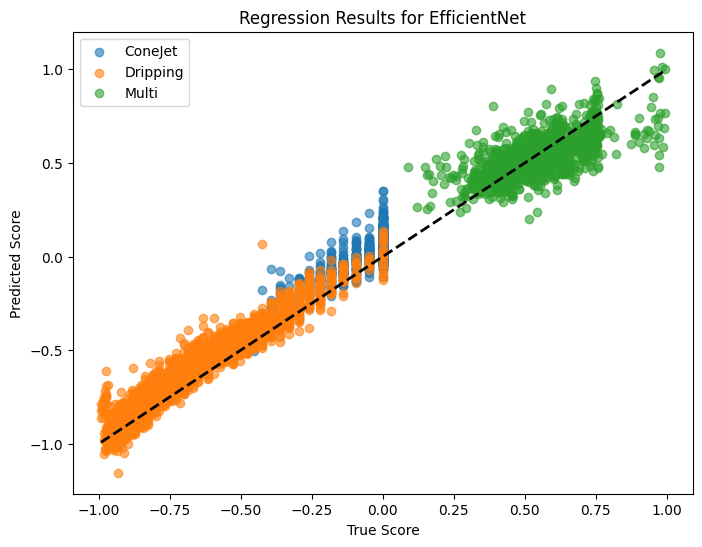

In [26]:
# 라벨별 시각화
evaluate_and_visualize_by_label(model, plot_loader, device=device)